In [2]:
#hide
import numpy as np 
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot as plt
import pandas as pd
plt.style.use('default')

%matplotlib inline

## Toy data


In [3]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 50)

print(x)

y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
#x = x.reshape(-1,1)

df = pd.DataFrame({'x' : x, "x_2": x, 'y' : y})

[ 0.          0.20408163  0.40816327  0.6122449   0.81632653  1.02040816
  1.2244898   1.42857143  1.63265306  1.83673469  2.04081633  2.24489796
  2.44897959  2.65306122  2.85714286  3.06122449  3.26530612  3.46938776
  3.67346939  3.87755102  4.08163265  4.28571429  4.48979592  4.69387755
  4.89795918  5.10204082  5.30612245  5.51020408  5.71428571  5.91836735
  6.12244898  6.32653061  6.53061224  6.73469388  6.93877551  7.14285714
  7.34693878  7.55102041  7.75510204  7.95918367  8.16326531  8.36734694
  8.57142857  8.7755102   8.97959184  9.18367347  9.3877551   9.59183673
  9.79591837 10.        ]


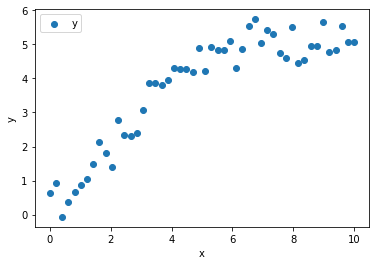

In [4]:
#hide_input
plt.scatter(x,y, label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## Boosting example

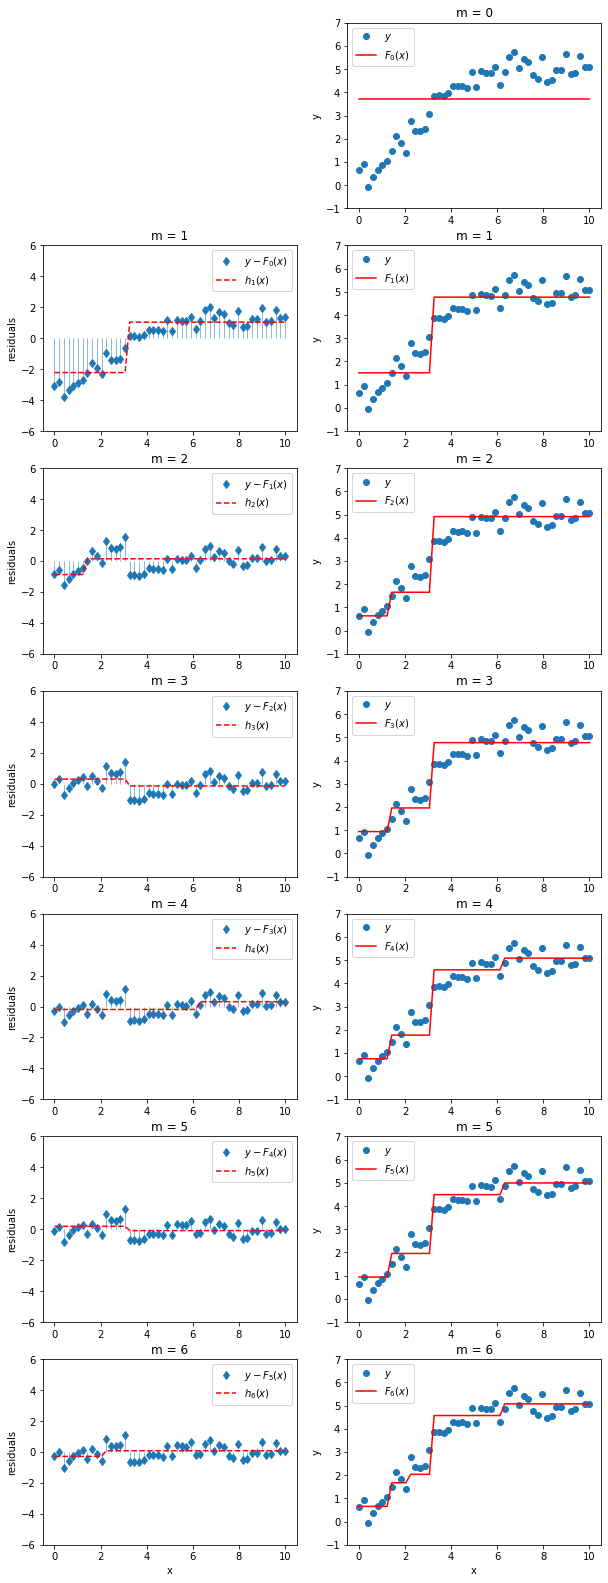

In [11]:

# hyperparameters
learning_rate = 1
n_trees = 6
max_depth = 1

# Training
F_0 = y.mean() * np.ones(shape=y.shape)
F0 = y.mean() 

fig, ax = plt.subplots(7,2, figsize=(10,28))

x = df[["x","x_2"]]

ax[0,0].axis('off')
ax[0,1].plot(x["x"], df["y"], 'o', label=r'$y$')
ax[0,1].plot(x["x"], F_0, '-r', label=r'$F_0(x)$')
ax[0,1].set_title('m = 0')
ax[0,1].set_ylabel('y')
ax[0,1].legend()
ax[0,1].set_ylim([-1,7]);

Fm = F0
trees = []
for i in range(n_trees):
    
    
    tree = split(x, np.array(df["y"])-Fm ,0,max_depth)

    m = i + 1
    
    preds = x.apply(predict, axis='columns', rules=tree.copy())
    
    ax[m,0].plot(x["x"], y - Fm, 'd', label=r'$y - F_{}(x)$'.format(m-1))
    ax[m,0].vlines(x["x"], 0, y - Fm, linewidth=0.5)
    ax[m,0].plot(x["x"], preds, '--r', label=r'$h_{}(x)$'.format(m))
    ax[m,0].legend()
    ax[m,0].set_ylim([-6, 6])
    ax[m,0].set_title('m = {}'.format(m))
    ax[m,0].set_ylabel('residuals')

    preds = x.apply(predict, axis='columns', rules=tree.copy())
    Fm += learning_rate * preds
    trees.append(tree)
    

    
    ax[m,1].plot(x["x"], y, 'o', label=r'$y$')
    ax[m,1].plot(x["x"], Fm, '-r', label=r'$F_{}(x)$'.format(m))
    ax[m,1].legend()
    ax[m,1].set_ylim([-1,7])
    ax[m,1].set_title('m = {}'.format(m))
    ax[m,1].set_ylabel('y')

ax[m,0].set_xlabel('x')
ax[m,1].set_xlabel('x');

ValueError: could not broadcast input array from shape (50,) into shape (100,)

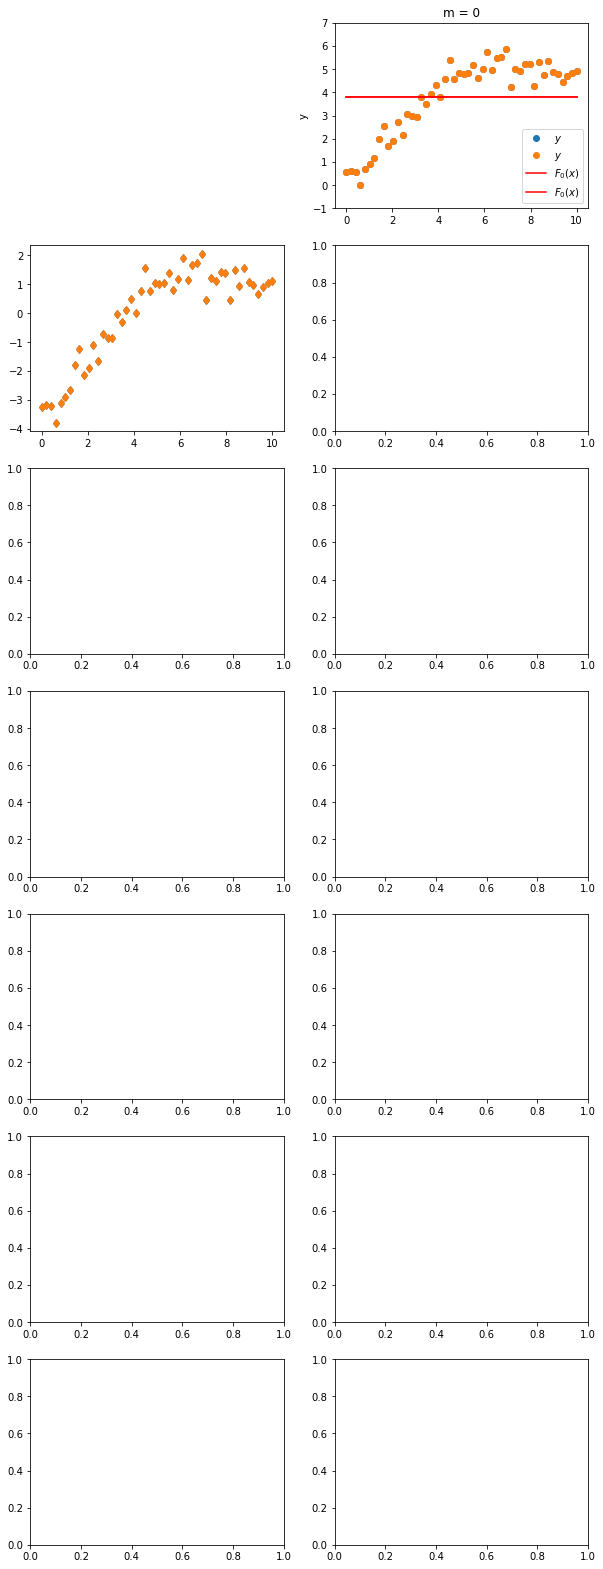

In [64]:
#hide_input
# hyperparameters
learning_rate = 1
n_trees = 6
max_depth = 1

# Training
F0 = y.mean() 

fig, ax = plt.subplots(7,2, figsize=(10,28))

ax[0,0].axis('off')
ax[0,1].plot(x, y, 'o', label=r'$y$')
ax[0,1].plot(x, F_0, '-r', label=r'$F_0(x)$')
ax[0,1].set_title('m = 0')
ax[0,1].set_ylabel('y')
ax[0,1].legend()
ax[0,1].set_ylim([-1,7]);

Fm = F0
trees = []
for i in range(n_trees):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(x, y - Fm)

    m = i + 1
    
    ax[m,0].plot(x, y - Fm, 'd', label=r'$y - F_{}(x)$'.format(m-1))
    ax[m,0].vlines(x, 0, y - Fm, linewidth=0.5)
    ax[m,0].plot(x, tree.predict(x), '--r', label=r'$h_{}(x)$'.format(m))
    ax[m,0].legend()
    ax[m,0].set_ylim([-6, 6])
    ax[m,0].set_title('m = {}'.format(m))
    ax[m,0].set_ylabel('residuals')

    Fm += learning_rate * tree.predict(x)
    trees.append(tree)
    
    print(tree.predict(x))

    
    ax[m,1].plot(x, y, 'o', label=r'$y$')
    ax[m,1].plot(x, Fm, '-r', label=r'$F_{}(x)$'.format(m))
    ax[m,1].legend()
    ax[m,1].set_ylim([-1,7])
    ax[m,1].set_title('m = {}'.format(m))
    ax[m,1].set_ylabel('y')

ax[m,0].set_xlabel('x')
ax[m,1].set_xlabel('x')

In [9]:
def find_best_rule(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    for feature in X_train.columns:
        thresholds = X_train[feature].unique().tolist()
        thresholds.sort()
        thresholds = thresholds[1:]
        for t in thresholds:
            y_left_ix = X_train[feature] < t
            y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
            t_rss = rss(y_left, y_right)
            if t_rss < min_rss:
                min_rss = t_rss
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold}



def split(X_train, y_train, depth, max_depth):
    if depth == max_depth or len(X_train) < 2:
        return {'prediction': np.mean(y_train)}
    
    rule = find_best_rule(X_train, y_train)
    left_ix = X_train[rule['feature']] < rule['threshold']
    rule['left'] = split(X_train[left_ix], y_train[left_ix], depth + 1, max_depth)
    rule['right'] = split(X_train[~left_ix], y_train[~left_ix], depth + 1, max_depth)
    return rule

def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature] < threshold:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction


def evaluate(X, y):
    preds = X.apply(predict, axis='columns', rules=rules.copy())
    return r2_score(preds, y)


def rss(y_left, y_right):
    def squared_residual_sum(y):
        return np.sum((y - np.mean(y)) ** 2)
    
    return squared_residual_sum(y_left) + squared_residual_sum(y_right) 
